In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy as sp

import h5py
import warnings
import random

from matplotlib import rcParams
from matplotlib import cm

warnings.filterwarnings('ignore')
%matplotlib inline

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['savefig.transparent'] = True

In [3]:
adata = sc.read('./matrix_clustered.h5ad')

### Find cluster markers

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_subclusters']`


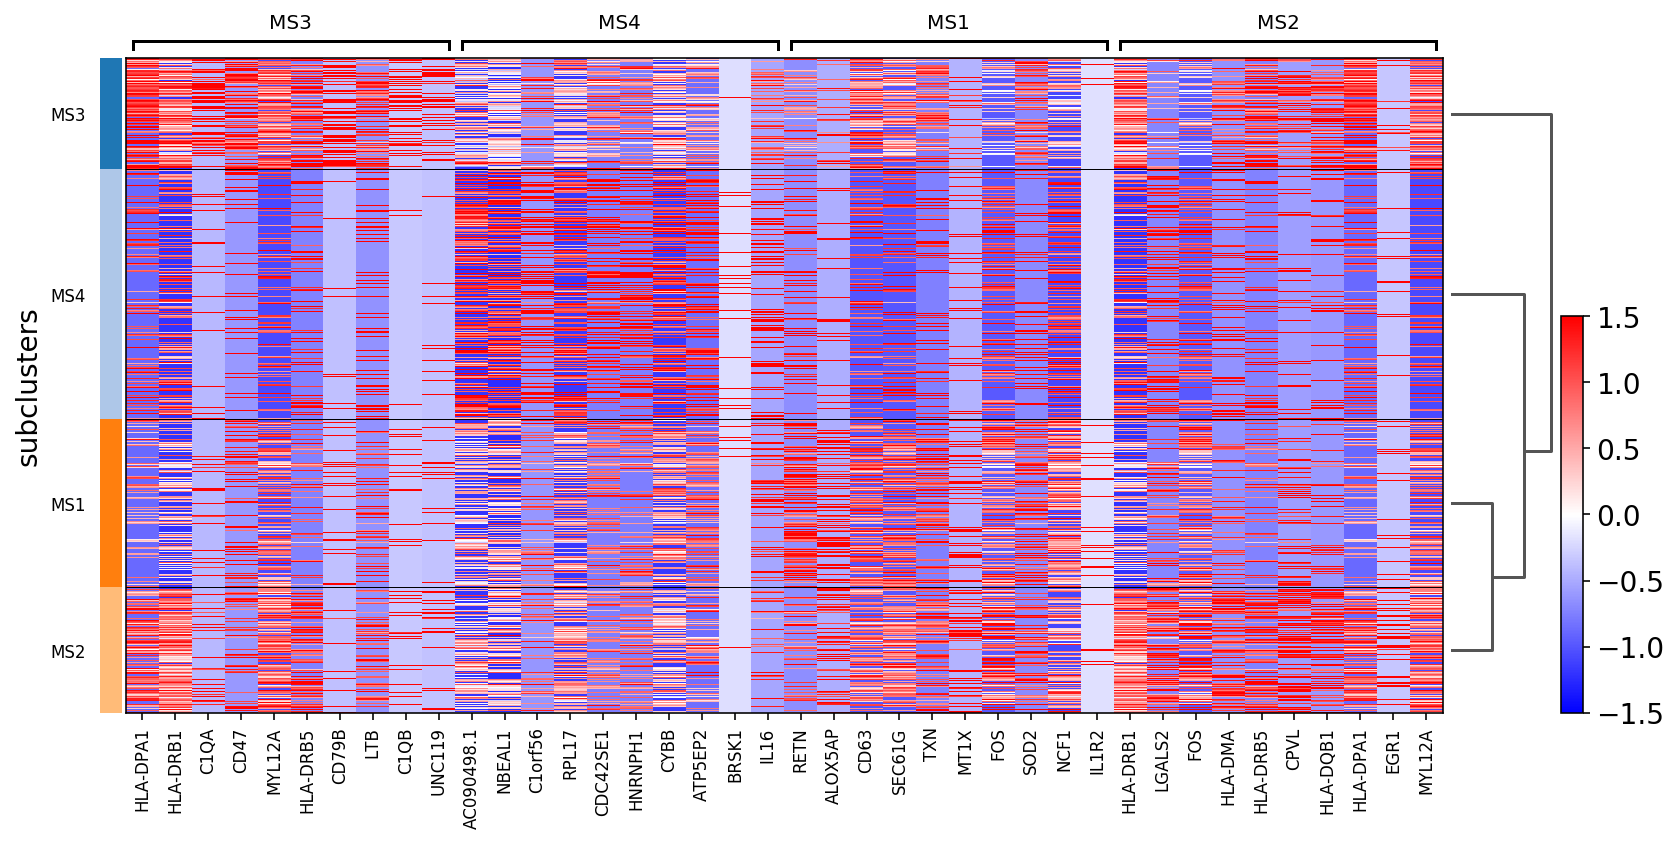

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_subclusters']`


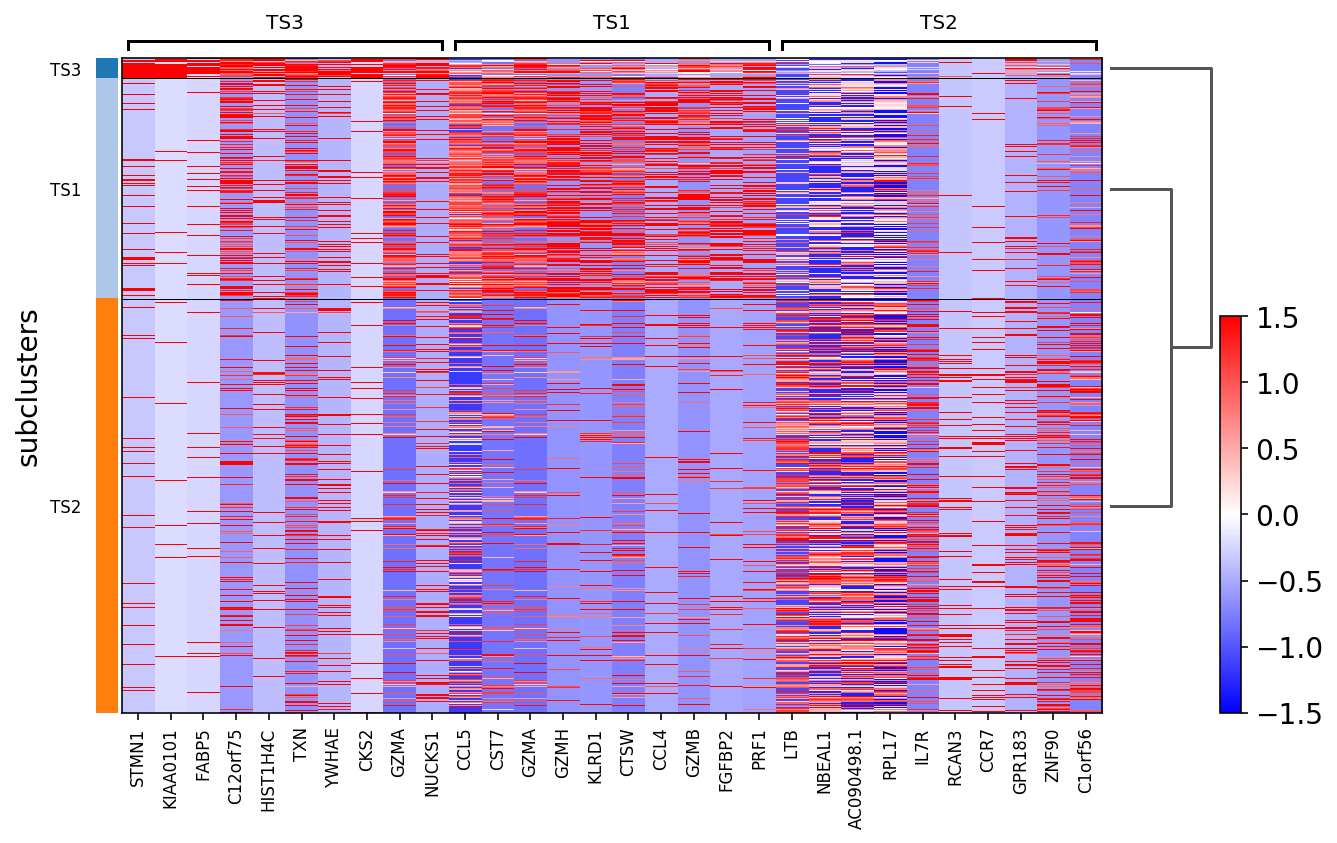

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_subclusters']`


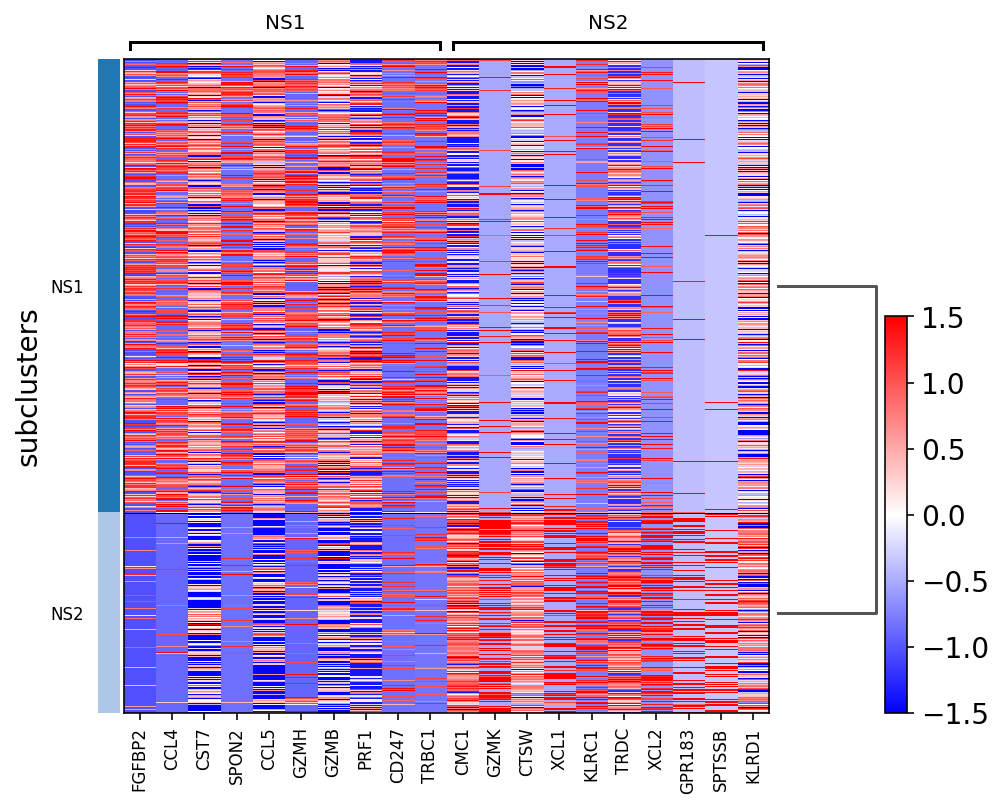

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_subclusters']`


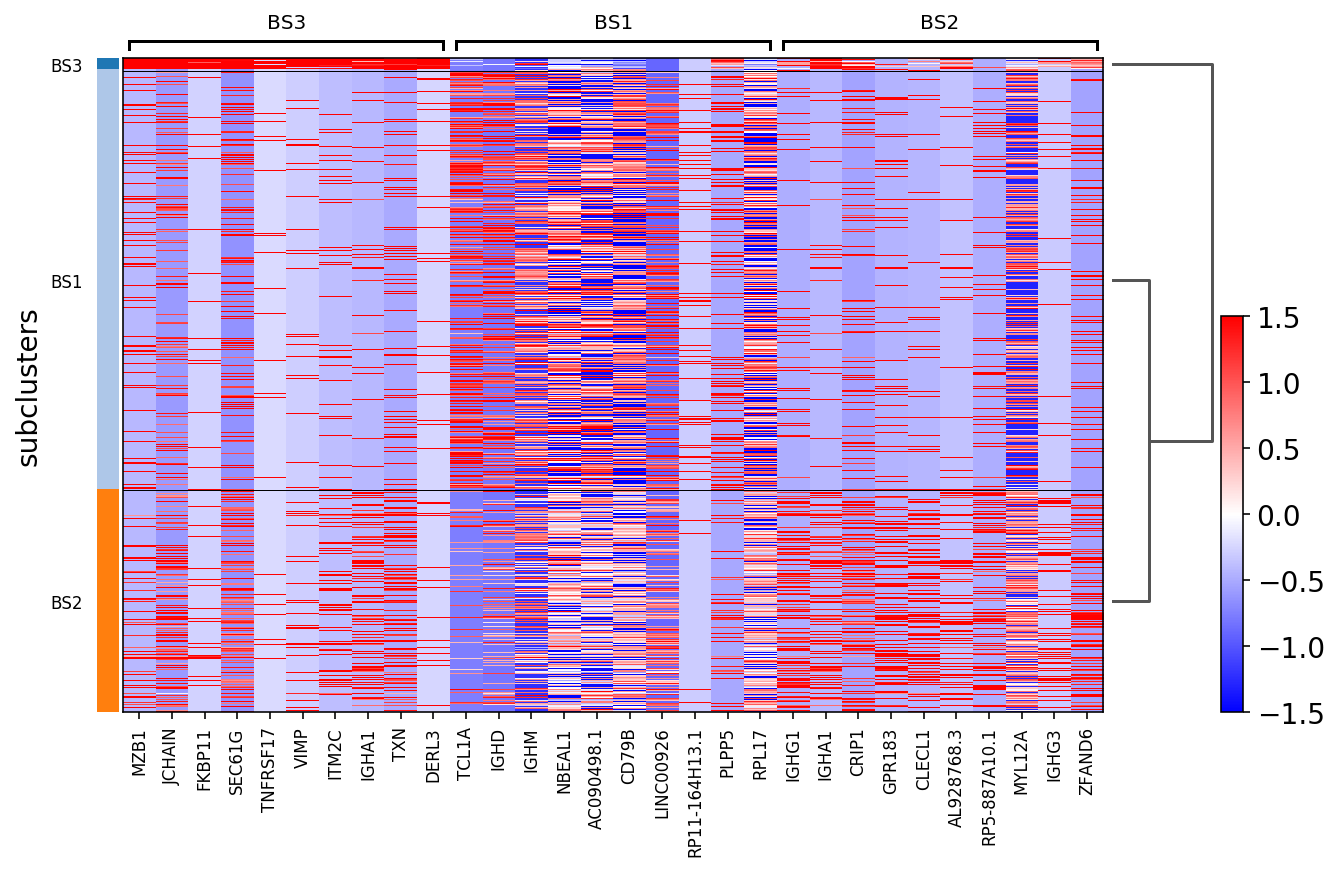

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_subclusters']`


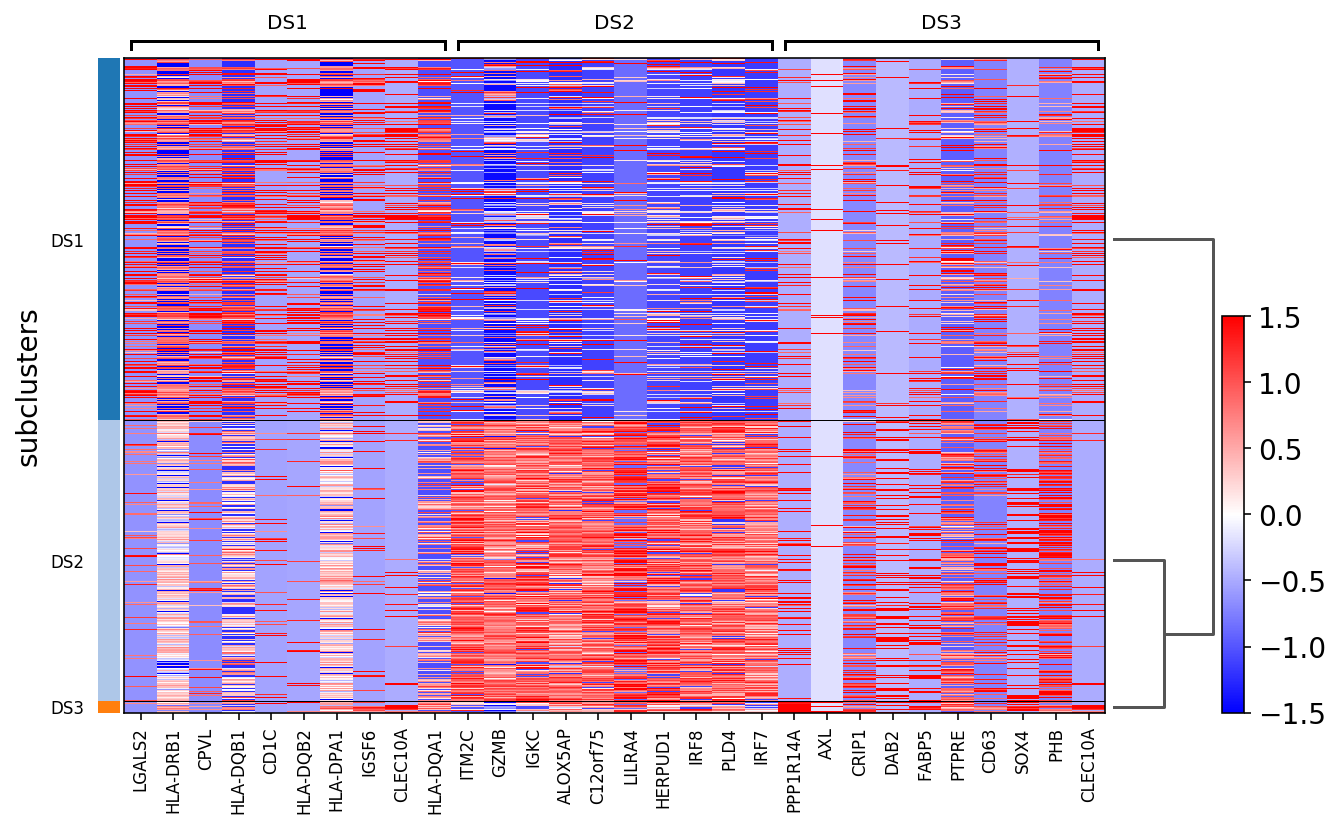

In [4]:
for lin in ['Mono','T','NK','B','DC']:
    adata_sub = adata[adata.obs['lineage']==lin]
    adata_sub.X = adata_sub.raw.X
    adata_sub = adata_sub[:,adata_sub.var['highly_variable']]
    sc.tl.rank_genes_groups(adata_sub, 'subclusters', n_genes=10, use_raw=False, method='wilcoxon')
    sc.pp.subsample(adata_sub, n_obs = 1000)
    sc.pp.scale(adata_sub)
    sc.pl.rank_genes_groups_heatmap(adata_sub, use_raw=False, vmin=-1.5, vmax=1.5, cmap='bwr')

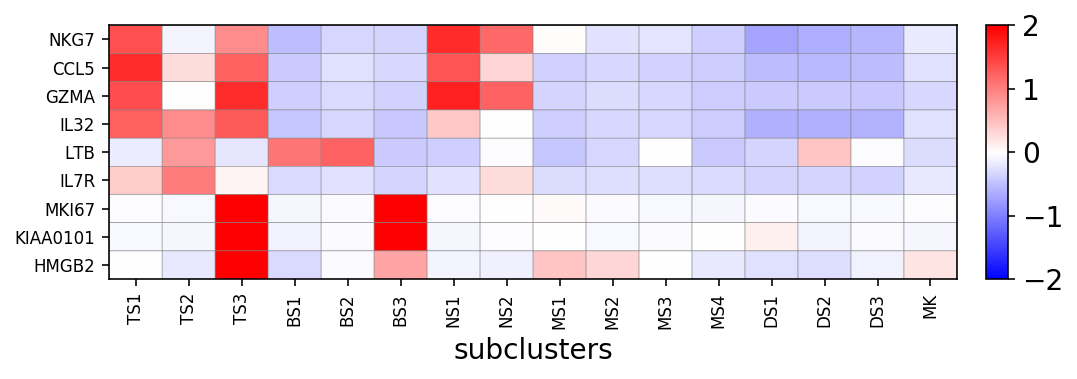

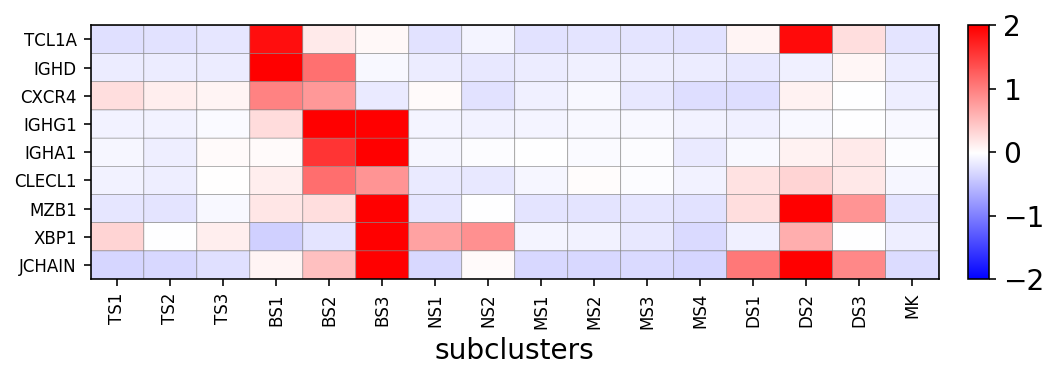

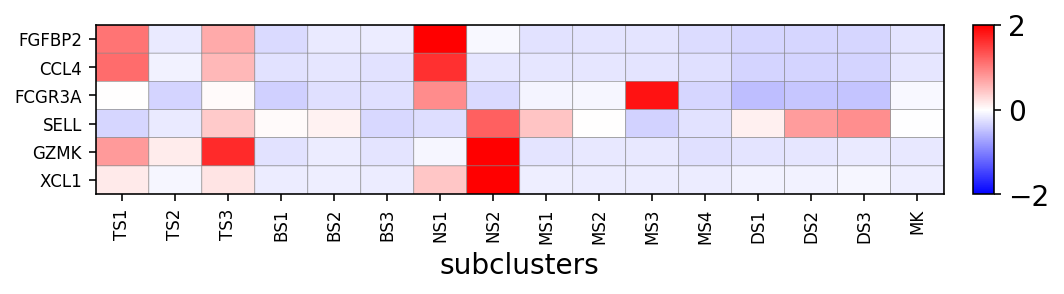

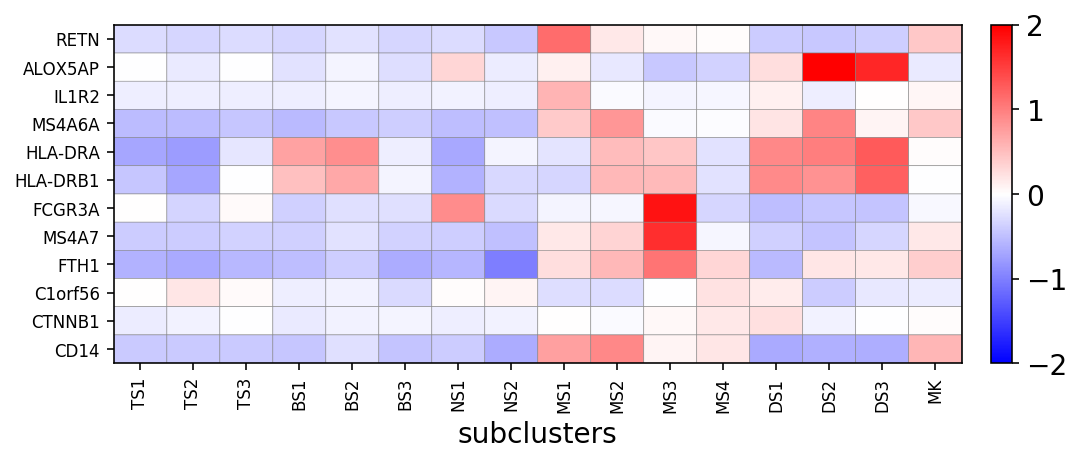

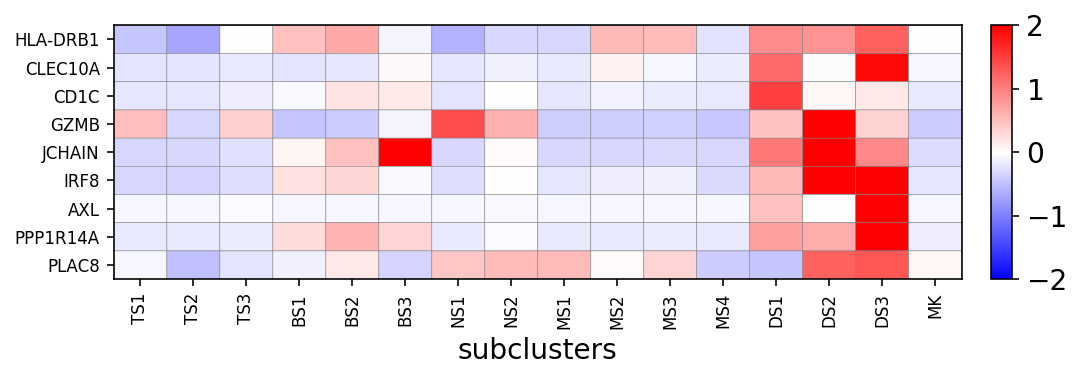

In [5]:
subcluster_markers = [['NKG7','CCL5','GZMA','IL32','LTB','IL7R','MKI67','KIAA0101','HMGB2'], #T cells
                      ['TCL1A','IGHD','CXCR4','IGHG1','IGHA1','CLECL1','MZB1','XBP1','JCHAIN'], #B cells
                      ['FGFBP2','CCL4','FCGR3A','SELL','GZMK','XCL1'], #NK cells
                      ['RETN','ALOX5AP','IL1R2','MS4A6A','HLA-DRA','HLA-DRB1','FCGR3A','MS4A7','FTH1',
                       'C1orf56','CTNNB1','CD14'], #Monocytes
                      ['HLA-DRB1','CLEC10A','CD1C','GZMB','JCHAIN','IRF8','AXL','PPP1R14A','PLAC8'], #Dendritic cells
                     ]

for i, marker_genes in enumerate(subcluster_markers):
    sc.pl.matrixplot(adata, marker_genes,
                 groupby='subclusters',
                 swap_axes=True,
                 use_raw=False, vmin=-2, vmax=2, cmap='bwr',
                 figsize=(8, 0.25*len(marker_genes)))

### Get patient and batch composition for each cluster

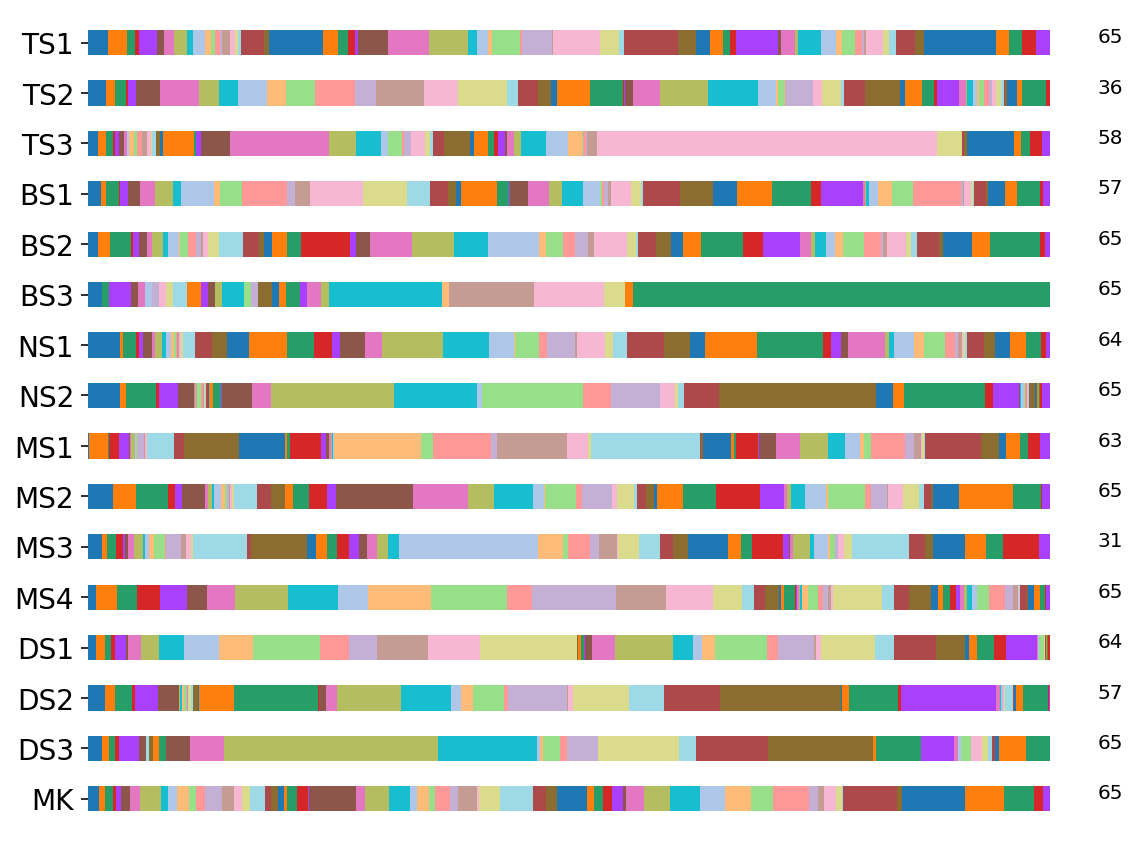

In [6]:
anno_subsets = 'subclusters'
anno_pointdef = 'patient'

## Get number of categories
subset_ids = adata.obs[anno_subsets].cat.categories.tolist()
n_subsets = len(subset_ids)
patient_ids = adata.obs[anno_pointdef].unique()
n_patients = len(patient_ids)

## Calculate patient fractions
subset_frac = pd.DataFrame(np.empty([n_patients, n_subsets]),
                                index = patient_ids ,
                                columns = subset_ids)
for i in np.arange(n_patients):
    ind2 = adata.obs[anno_pointdef] == patient_ids[i]
    for j in np.arange(n_subsets):
        ind1 = adata.obs[anno_subsets] == subset_ids[j]
        subset_frac.iloc[i,j] = sum(ind1&ind2)
subset_frac = subset_frac.transpose()
subset_frac = subset_frac.apply(lambda x: x/sum(x),axis=1)

## Add re-ordered barplot
fig, axes = plt.subplots(1,1, figsize=(8,6))

subset_frac.iloc[::-1].plot.barh(stacked=True, grid=False, legend=False, ax=axes)

for i in range(16):
    n_s = sum(subset_frac.iloc[i] > 0)
    plt.text(1.05, i, n_s)
    
axes.grid(False), axes.set_xticks([])
sns.despine(left=True, bottom=True, right=True)
plt.tight_layout()

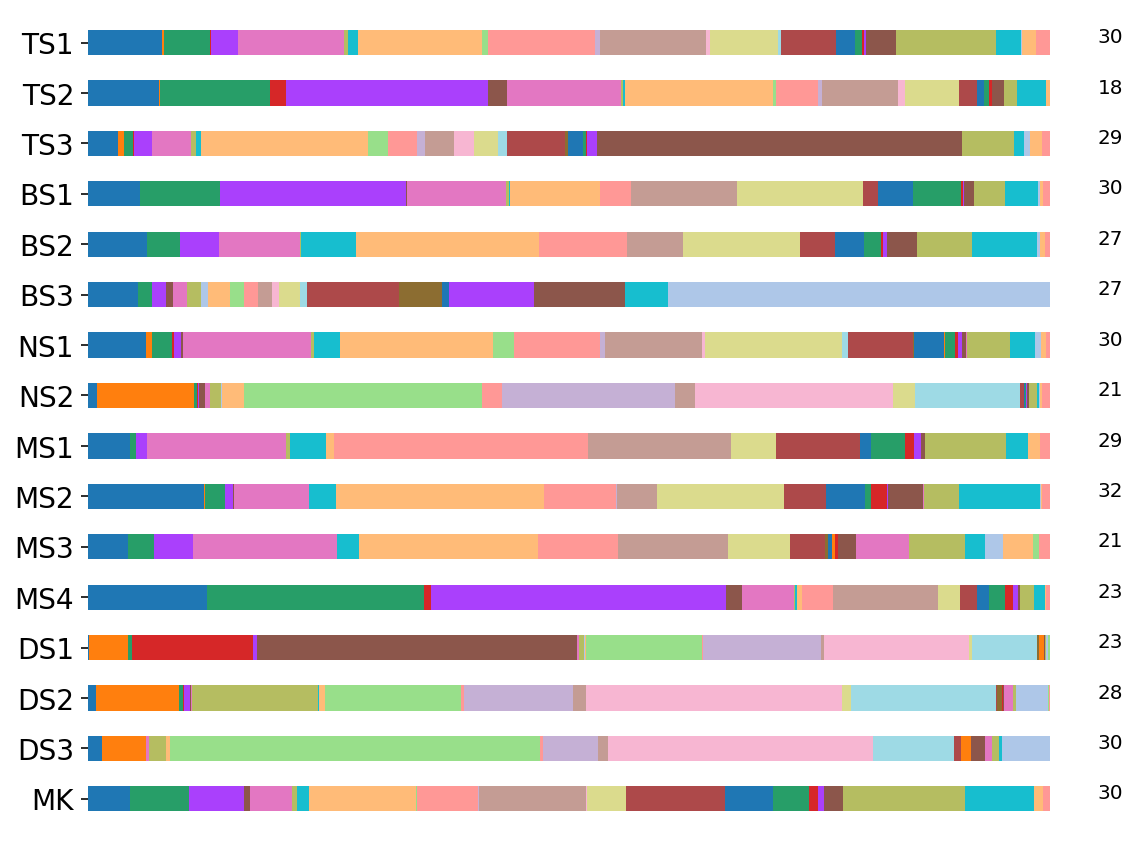

In [7]:
anno_subsets = 'subclusters'
anno_pointdef = 'channel'

## Get number of categories
subset_ids = adata.obs[anno_subsets].cat.categories.tolist()
n_subsets = len(subset_ids)
patient_ids = adata.obs[anno_pointdef].unique()
n_patients = len(patient_ids)

## Calculate patient fractions
subset_frac = pd.DataFrame(np.empty([n_patients, n_subsets]),
                                index = patient_ids ,
                                columns = subset_ids)
for i in np.arange(n_patients):
    ind2 = adata.obs[anno_pointdef] == patient_ids[i]
    for j in np.arange(n_subsets):
        ind1 = adata.obs[anno_subsets] == subset_ids[j]
        subset_frac.iloc[i,j] = sum(ind1&ind2)
subset_frac = subset_frac.transpose()
subset_frac = subset_frac.apply(lambda x: x/sum(x),axis=1)

## Add re-ordered barplot
fig, axes = plt.subplots(1,1, figsize=(8,6))

subset_frac.iloc[::-1].plot.barh(stacked=True, grid=False, legend=False, ax=axes)

for i in range(16):
    n_s = sum(subset_frac.iloc[i] > 0)
    plt.text(1.05, i, n_s)
    
axes.grid(False), axes.set_xticks([])
sns.despine(left=True, bottom=True, right=True)
plt.tight_layout()

### Plot density maps

In [8]:
adata.obs['sepsis'] = 'SEP'
adata.obs['sepsis'][adata.obs['pheno'].isin(['Control','Leuk-UTI','ICU-NoSEP'])] = 'NoSEP'

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:11)
computing tSNE
    using 'X_pca' with n_pcs = 10
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:56)


... storing 'sepsis' as categorical


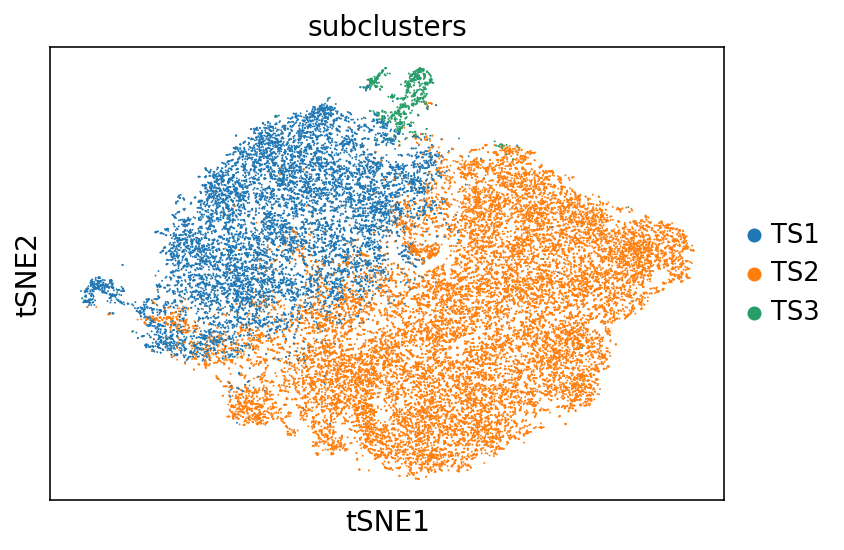

computing density on 'tsne'
--> added
    'tsne_density_sepsis', densities (adata.obs)
    'tsne_density_sepsis_params', parameter (adata.uns)


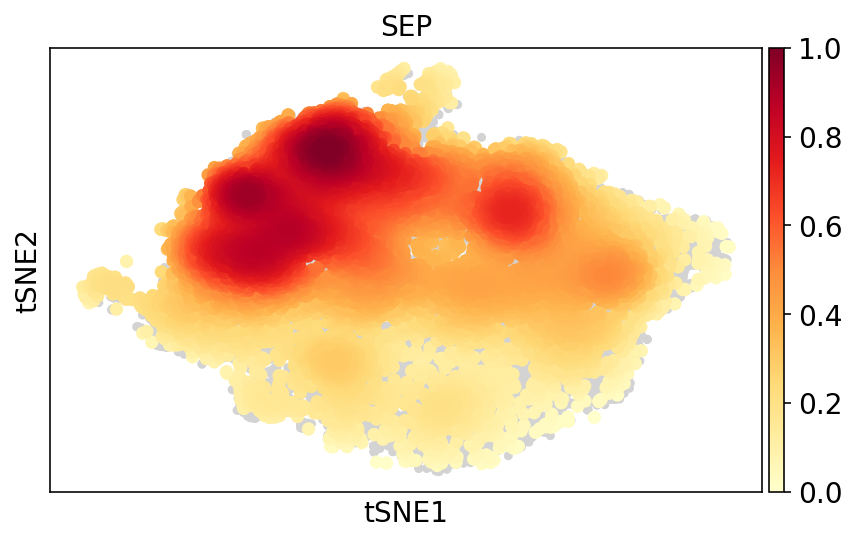

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:02)
computing tSNE
    using 'X_pca' with n_pcs = 10
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:20)


... storing 'sepsis' as categorical


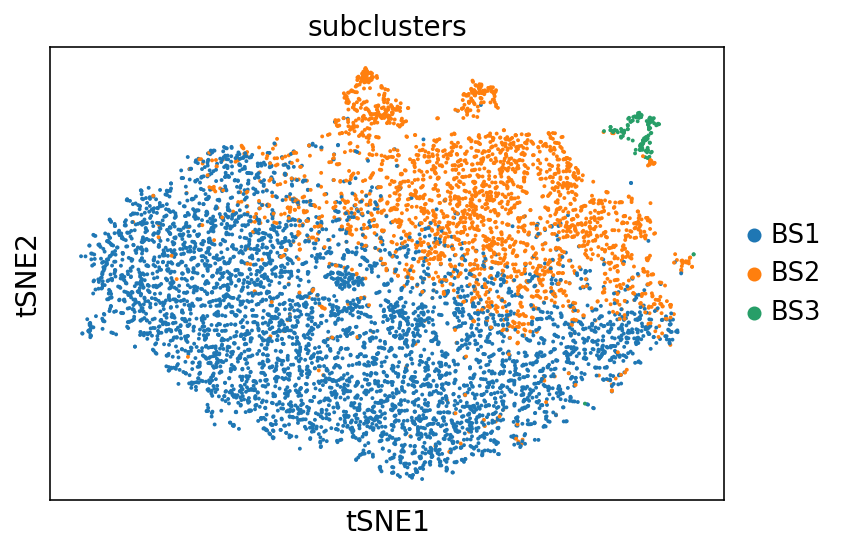

computing density on 'tsne'
--> added
    'tsne_density_sepsis', densities (adata.obs)
    'tsne_density_sepsis_params', parameter (adata.uns)


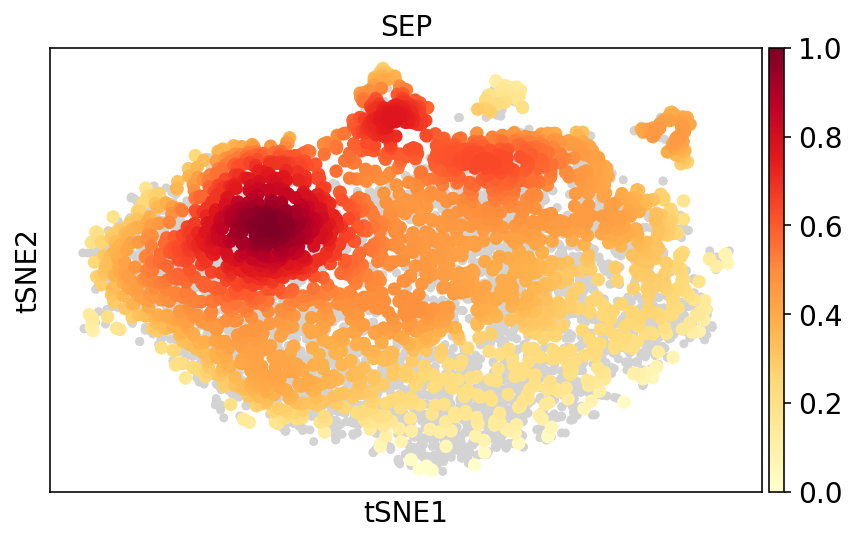

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:02)
computing tSNE
    using 'X_pca' with n_pcs = 10
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:24)


... storing 'sepsis' as categorical


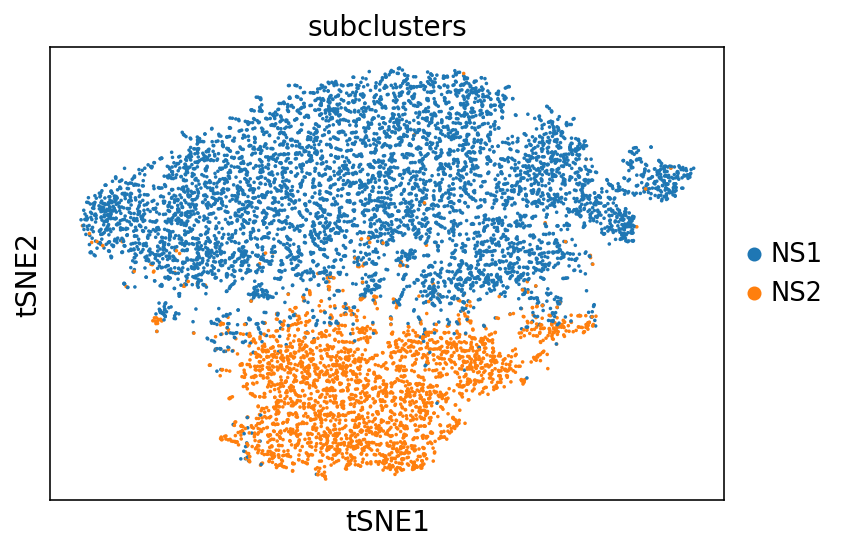

computing density on 'tsne'
--> added
    'tsne_density_sepsis', densities (adata.obs)
    'tsne_density_sepsis_params', parameter (adata.uns)


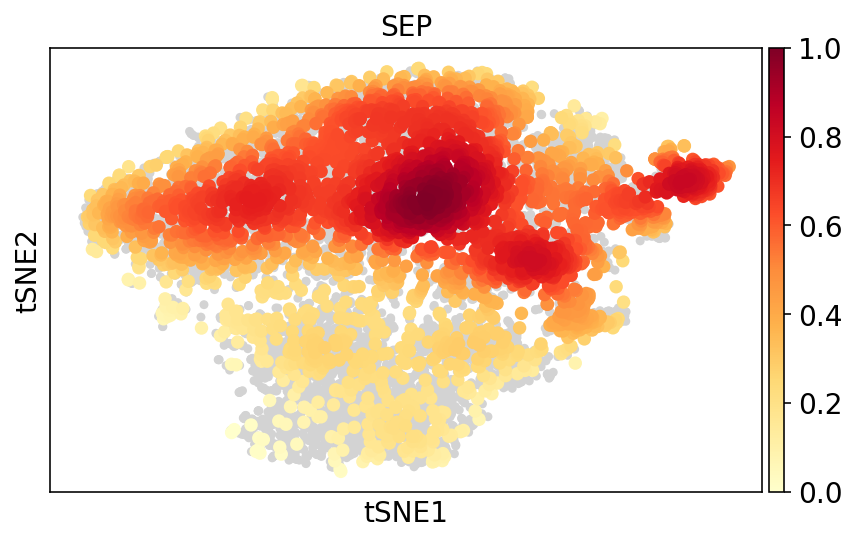

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:13)
computing tSNE
    using 'X_pca' with n_pcs = 10
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:03:46)


... storing 'sepsis' as categorical


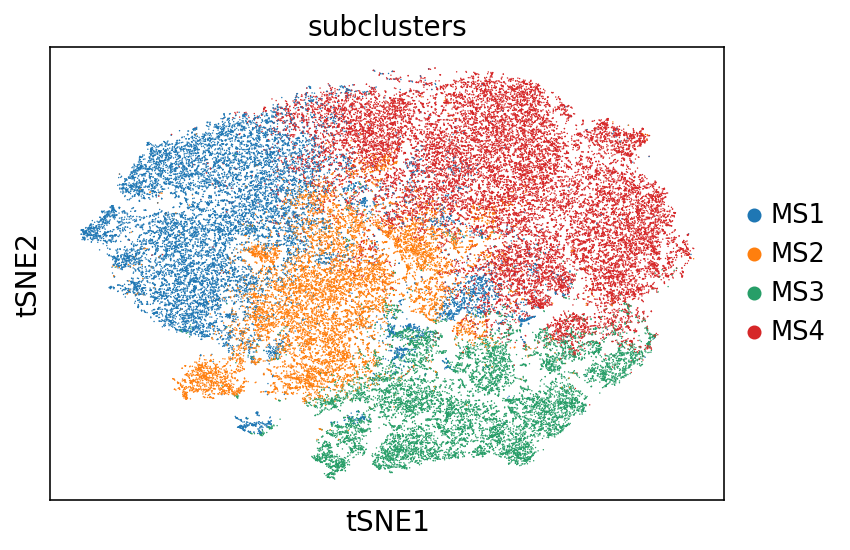

computing density on 'tsne'
--> added
    'tsne_density_sepsis', densities (adata.obs)
    'tsne_density_sepsis_params', parameter (adata.uns)


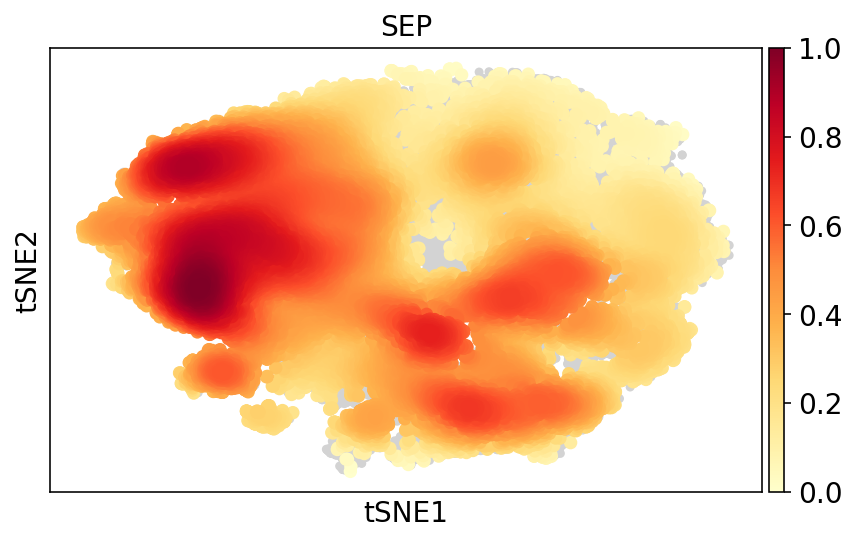

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:09)
computing tSNE
    using 'X_pca' with n_pcs = 10
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:37)


... storing 'sepsis' as categorical


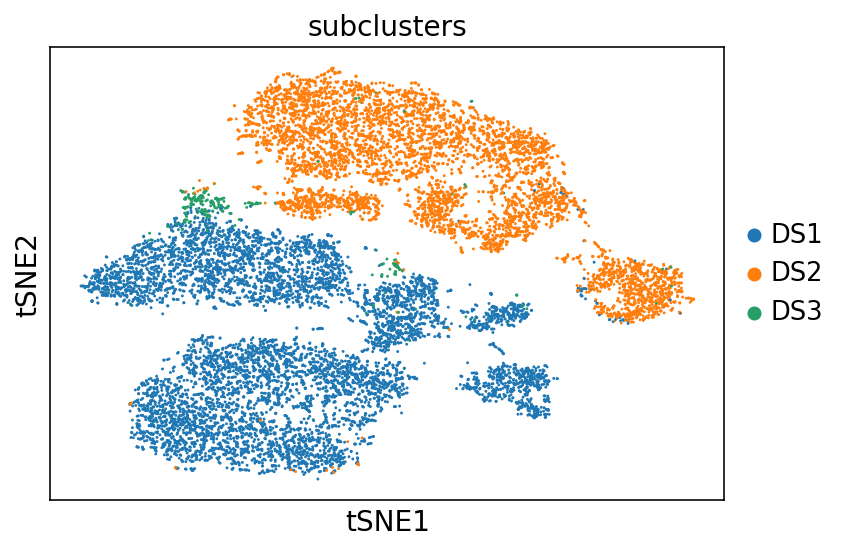

computing density on 'tsne'
--> added
    'tsne_density_sepsis', densities (adata.obs)
    'tsne_density_sepsis_params', parameter (adata.uns)


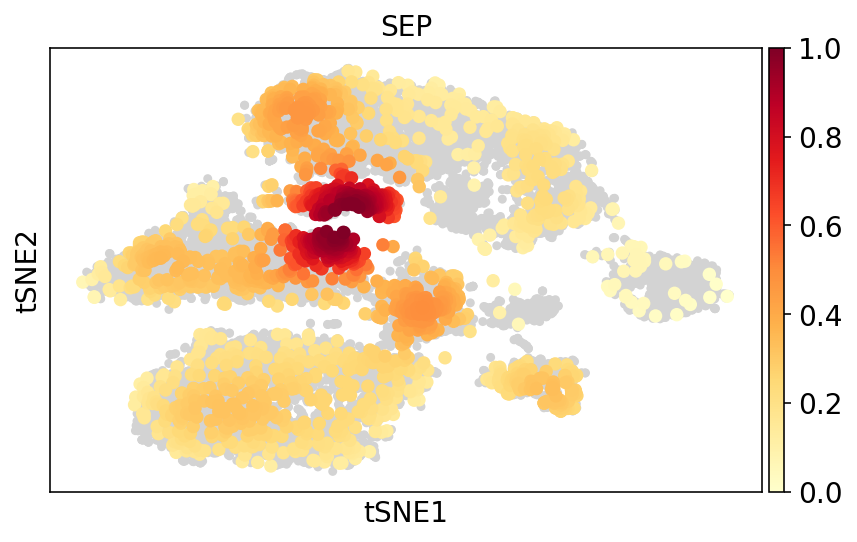

In [9]:
for lin in ['T','B','NK','Mono','DC']:
    adata_sub = adata[adata.obs['lineage']==lin]
    adata_sub.X = adata_sub.raw.X
    sc.pp.highly_variable_genes(adata_sub, subset=False)
    sc.pp.scale(adata_sub)
    sc.pp.pca(adata_sub, use_highly_variable=True, svd_solver='arpack')
    sc.tl.tsne(adata_sub, n_pcs=10)
    sc.pl.tsne(adata_sub, color=['subclusters'])
    sc.tl.embedding_density(adata_sub, basis='tsne', groupby='sepsis')
    sc.pl.embedding_density(adata_sub, basis='tsne', key='tsne_density_sepsis' ,group='SEP')
    del (adata_sub)

### Differential Expression on ICU-SEP vs. ICU-NoSEP

In [10]:
adata_sub = adata[(adata.obs['pheno'].isin(['ICU-NoSEP','ICU-SEP'])) & (adata.obs['subclusters']=='MS1')]
adata_sub.obs['patient'] = adata_sub.obs['patient'].cat.reorder_categories(['P633','P636','P640',
                                                                            'P662','P669','P670',
                                                                            'P671','P672',
                                                                            'P634','P635','P639',
                                                                            'P650','P657','P667',
                                                                            'P668'])
adata_sub.X = adata_sub.raw.X
sc.pp.scale(adata_sub)
sc.tl.rank_genes_groups(adata_sub, groupby='pheno', n_genes=5000, method='wilcoxon',
                        groups=['ICU-SEP','ICU-NoSEP'])

Trying to set attribute `.obs` of view, making a copy.


ranking genes


... storing 'sepsis' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


Filtering genes using: min_in_group_fraction: 0.4 min_fold_change: 0, max_out_group_fraction: 0.6


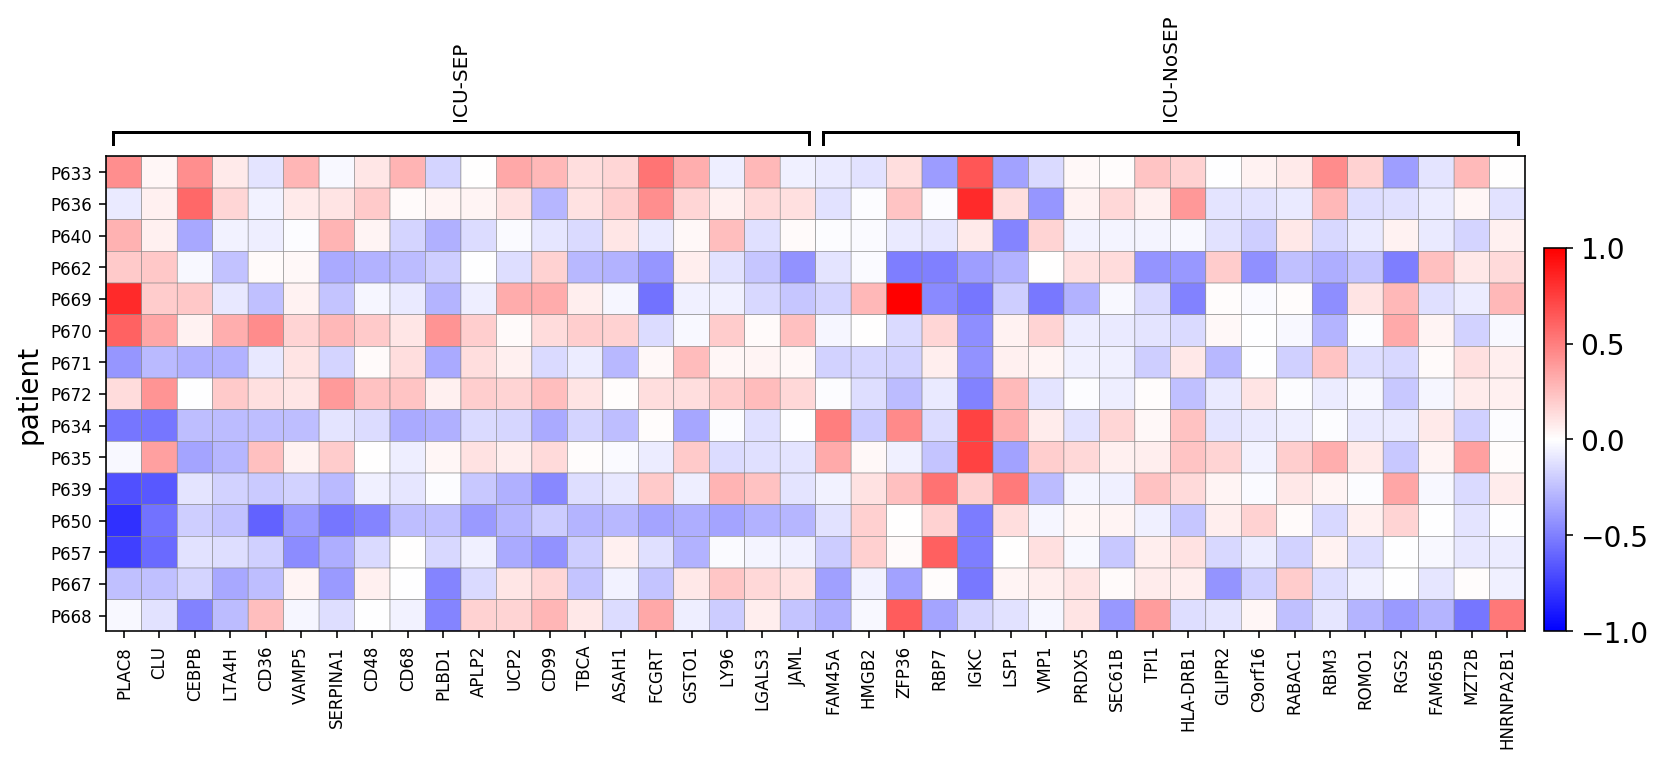

In [11]:
sc.tl.filter_rank_genes_groups(adata_sub, min_fold_change=0, max_out_group_fraction=0.6, min_in_group_fraction=0.4)
sc.pl.rank_genes_groups_matrixplot(adata_sub, groupby='patient', cmap='bwr', use_raw=False, dendrogram=False,
                                   key='rank_genes_groups_filtered', n_genes=20, vmin=-1, vmax=1)

Plot volcano

In [12]:
sc.tl.rank_genes_groups(adata_sub, groupby='pheno', groups=['ICU-SEP'], reference='ICU-NoSEP', n_genes=5000,
                        method='wilcoxon')

sc.tl.rank_genes_groups(adata_sub, groupby='pheno', groups=['ICU-NoSEP'], reference='ICU-SEP', n_genes=5000,
                        key_added='rank_genes_groups_ICU', method='wilcoxon')

volcano_df = pd.DataFrame(adata_sub.uns['rank_genes_groups']['logfoldchanges']['ICU-SEP'], 
                          index=adata_sub.uns['rank_genes_groups']['names']['ICU-SEP'],
                          columns=['logFC'])
volcano_df['-log10p'] = -np.log10(adata_sub.uns['rank_genes_groups']['pvals_adj']['ICU-SEP'])

volcano_neg_df = pd.DataFrame(-adata_sub.uns['rank_genes_groups_ICU']['logfoldchanges']['ICU-NoSEP'], 
                          index=adata_sub.uns['rank_genes_groups_ICU']['names']['ICU-NoSEP'],
                          columns=['logFC'])
volcano_neg_df['-log10p'] = -np.log10(adata_sub.uns['rank_genes_groups_ICU']['pvals_adj']['ICU-NoSEP'])

volcano_df = volcano_df[volcano_df.index.notna()]
volcano_df = volcano_df.append(volcano_neg_df)
volcano_df = volcano_df[volcano_df['-log10p'] > 1]
volcano_df = volcano_df.sort_values('logFC', ascending=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)
ranking genes
    finished: added to `.uns['rank_genes_groups_ICU']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


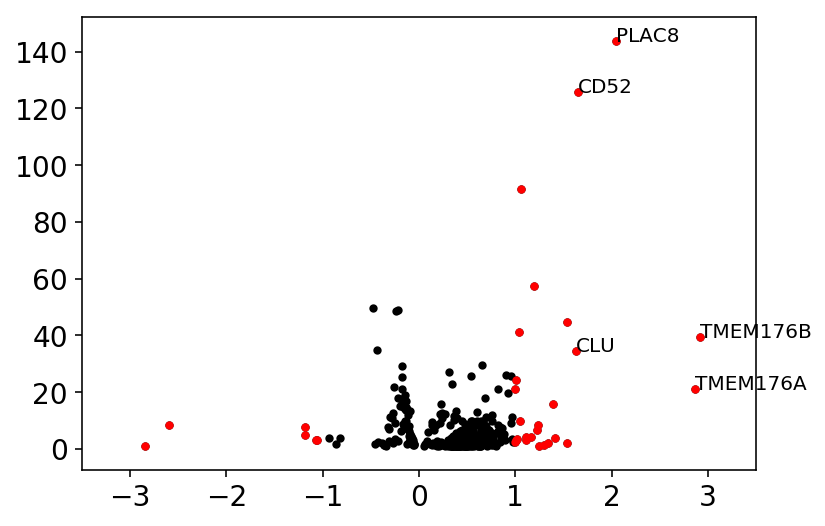

In [13]:
plt.scatter(volcano_df['logFC'],volcano_df['-log10p'], s=10, c='k')
plt.scatter(volcano_df['logFC'][volcano_df['logFC']>1],volcano_df['-log10p'][volcano_df['logFC']>1],
            s=10, c='red')
plt.scatter(volcano_df['logFC'][volcano_df['logFC']<-1],volcano_df['-log10p'][volcano_df['logFC']<-1],
            s=10, c='red')
plt.xlim([-3.5,3.5])
plt.grid(False)
for i, txt in enumerate(volcano_df.index[:5]):
    plt.annotate(txt, (volcano_df['logFC'][i], volcano_df['-log10p'][i]), size=10)

Plot average expression of CLU and PLAC8 across SEP and ICU-SEP patients

(0, 5)

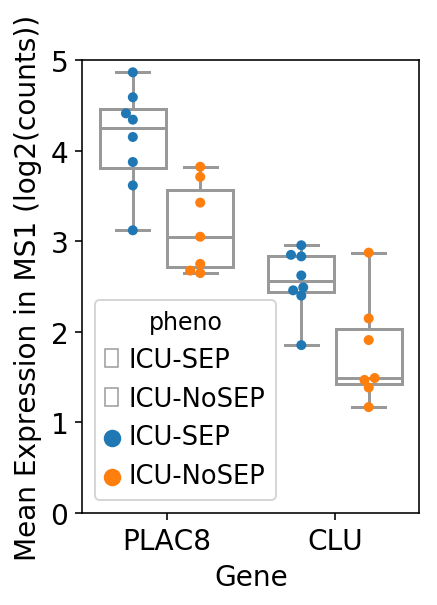

In [14]:
genes = ['PLAC8','CLU']

adata_sub.X = adata_sub.raw.X
adata_plac8 = adata_sub[:,genes]
gex_df = pd.DataFrame(adata_plac8.X.toarray(), index=adata_plac8.obs_names, 
                      columns=genes)

gex_df = np.expm1(gex_df)
gex_df['patient'] = adata_plac8.obs['patient']
gex_df['pheno'] = adata_plac8.obs['pheno']
gex_df = gex_df.groupby(['patient'], as_index=True)[genes].mean()
gex_df = np.log2(gex_df+2)
gex_df['pheno'] = adata_plac8.obs[['patient','pheno']].groupby(['patient']).first()
gex_df = gex_df.melt(id_vars='pheno', value_vars= genes)

plt.figure(figsize=(3,4))
sns.boxplot(x='variable', y='value', hue='pheno', data=gex_df, fliersize=0, palette=['white','white'])
sns.swarmplot(x='variable', y='value', hue='pheno', data=gex_df, dodge=True)
plt.grid(False)
plt.ylabel('Mean Expression in MS1 (log2(counts))')
plt.xlabel('Gene')
plt.ylim([0,5])